# Cryptocurrency (AVAX) price prediction with Incremental/Online Learning

my accounts -> [github](https://github.com/john-fante), [kaggle](https://www.kaggle.com/banddaniel)

Goal 1 : Prediction the daily Close price of AVAX using BTC and ETH data <br>
Goal 2 : In addition time series data and prediction the daily Close price of AVAX using BTC and ETH data

Data Source -> https://www.yahoo.com

I have used the following methods.

* I modified original examples [1],
* Applied cos, sin transform for the quarter data (time series feature extraction),

## References
1. https://riverml.xyz

In [77]:
# Importing dependencies

from IPython.display import clear_output, set_matplotlib_formats
set_matplotlib_formats('retina')

!pip install river
!pip install pytest

clear_output()


from river import compose, linear_model, metrics, evaluate, preprocessing, optim, stream, utils
import itertools
from pprint import pprint 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [90]:
# Reading AVAX price and dropping columns

data_avax = pd.read_csv('/Users/arturo/Downloads/AVAX-USD.csv')
data_avax.index = pd.to_datetime( data_avax['Date'])
data_avax.drop(['Adj Close', 'Volume', 'Date'], axis = 1, inplace = True)

def app_prefix(a):
    new = 'avax_' + a
    return new

data_avax.rename(app_prefix , axis='columns', inplace = True)

data_avax.head()

,avax_Open,avax_High,avax_Low,avax_Close
Date,,,,
2022-11-20,12.881950,13.117833,12.131300,12.196779
2022-11-21,12.196135,12.196135,11.647357,11.834380
2022-11-22,11.833281,12.350505,11.492087,12.322193
2022-11-23,12.324512,13.031652,12.324512,13.031652
2022-11-24,13.030243,13.365598,12.805801,12.940833


In [91]:
# Reading BTC price and dropping columns

data_btc = pd.read_csv('/Users/arturo/Downloads/BTC-USD.csv')
data_btc.index = pd.to_datetime(data_btc['Date'])
data_btc.drop(['Adj Close', 'Volume','Date'], axis = 1, inplace = True)

def app_prefix(a):
    new = 'btc_' + a
    return new

data_btc.rename(app_prefix , axis='columns', inplace = True)

data_btc.head()

,btc_Open,btc_High,btc_Low,btc_Close
Date,,,,
2022-11-20,16712.919922,16746.779297,16248.692383,16291.832031
2022-11-21,16291.223633,16291.223633,15599.046875,15787.284180
2022-11-22,15782.300781,16253.047852,15656.606445,16189.769531
2022-11-23,16195.588867,16638.193359,16170.502930,16610.707031
2022-11-24,16611.636719,16771.474609,16501.767578,16604.464844


In [92]:
# Reading ETH price and dropping columns

data_eth = pd.read_csv('/Users/arturo/Downloads/ETH-USD.csv')
data_eth.index = pd.to_datetime( data_eth['Date'])
data_eth.drop(['Adj Close', 'Volume', 'Date'], axis = 1, inplace = True)

def app_prefix(a):
    new = 'eth_' + a
    return new

data_eth.rename(app_prefix , axis='columns', inplace = True)

data_eth.head()

,eth_Open,eth_High,eth_Low,eth_Close
Date,,,,
2022-11-20,1218.436279,1224.077759,1137.933228,1142.466675
2022-11-21,1142.395752,1142.395752,1084.857300,1108.353027
2022-11-22,1107.895996,1136.442627,1081.138184,1135.173462
2022-11-23,1135.421509,1184.997314,1130.022827,1183.199585
2022-11-24,1183.345093,1211.627441,1180.379761,1203.983154


In [93]:
# Joining all data (AVAX, BTC, ETH)

data = data_avax.join(data_btc)
data = data.join(data_eth)

data.head()

,avax_Open,avax_High,avax_Low,avax_Close,btc_Open,btc_High,btc_Low,btc_Close,eth_Open,eth_High,eth_Low,eth_Close
Date,,,,,,,,,,,,
2022-11-20,12.881950,13.117833,12.131300,12.196779,16712.919922,16746.779297,16248.692383,16291.832031,1218.436279,1224.077759,1137.933228,1142.466675
2022-11-21,12.196135,12.196135,11.647357,11.834380,16291.223633,16291.223633,15599.046875,15787.284180,1142.395752,1142.395752,1084.857300,1108.353027
2022-11-22,11.833281,12.350505,11.492087,12.322193,15782.300781,16253.047852,15656.606445,16189.769531,1107.895996,1136.442627,1081.138184,1135.173462
2022-11-23,12.324512,13.031652,12.324512,13.031652,16195.588867,16638.193359,16170.502930,16610.707031,1135.421509,1184.997314,1130.022827,1183.199585
2022-11-24,13.030243,13.365598,12.805801,12.940833,16611.636719,16771.474609,16501.767578,16604.464844,1183.345093,1211.627441,1180.379761,1203.983154


In [94]:
# Creating the River stream for model

y = data.pop('avax_Close')
X_y = stream.iter_pandas(data,y)


model = compose.Select('avax_Open', 'avax_High', 'avax_Low', 'btc_Open',
       'btc_High', 'btc_Low', 'btc_Close', 'eth_Open', 'eth_High', 'eth_Low', 'eth_Close')

model |= preprocessing.MinMaxScaler()
model |= linear_model.LinearRegression(optimizer = optim.SGD(0.01))

model

Pipeline (
  Select (
    avax_High
    avax_Low
    avax_Open
    btc_Close
    btc_High
    btc_Low
    btc_Open
    eth_Close
    eth_High
    eth_Low
    eth_Open
  ),
  MinMaxScaler (),
  LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
)

In [95]:
# Model evaluation function

def evaluate_model(dataset, model, window_size = 5, title =''): 

    mae_metric = utils.Rolling(metrics.MAE() , window_size = window_size)
    rmse_metric = utils.Rolling(metrics.RMSE() , window_size = window_size)

    dates = data.index
    y_trues = []
    y_preds = []
    
    for x, y in dataset:

        y_pred = model.predict_one(x)
        model.learn_one(x, y)
        mae_metric.update(y, y_pred)
        rmse_metric.update(y, y_pred)
    
        y_trues.append(y)
        y_preds.append(y_pred)

    # Plot the results
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.grid(alpha=0.5)
    ax.plot(dates, y_trues, lw=2, color='#2ecc71', alpha=0.8, label='Ground truth')
    ax.plot(dates, y_preds, lw=1, color='#bf1833', alpha=0.8, label='Prediction')
    ax.legend()
    ax.set_title(str(title) + str(mae_metric) + ' - ' + str(rmse_metric))

/opt/anaconda3/lib/python3.9/site-packages/river/preprocessing/scale.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return a / b if b else 0.0


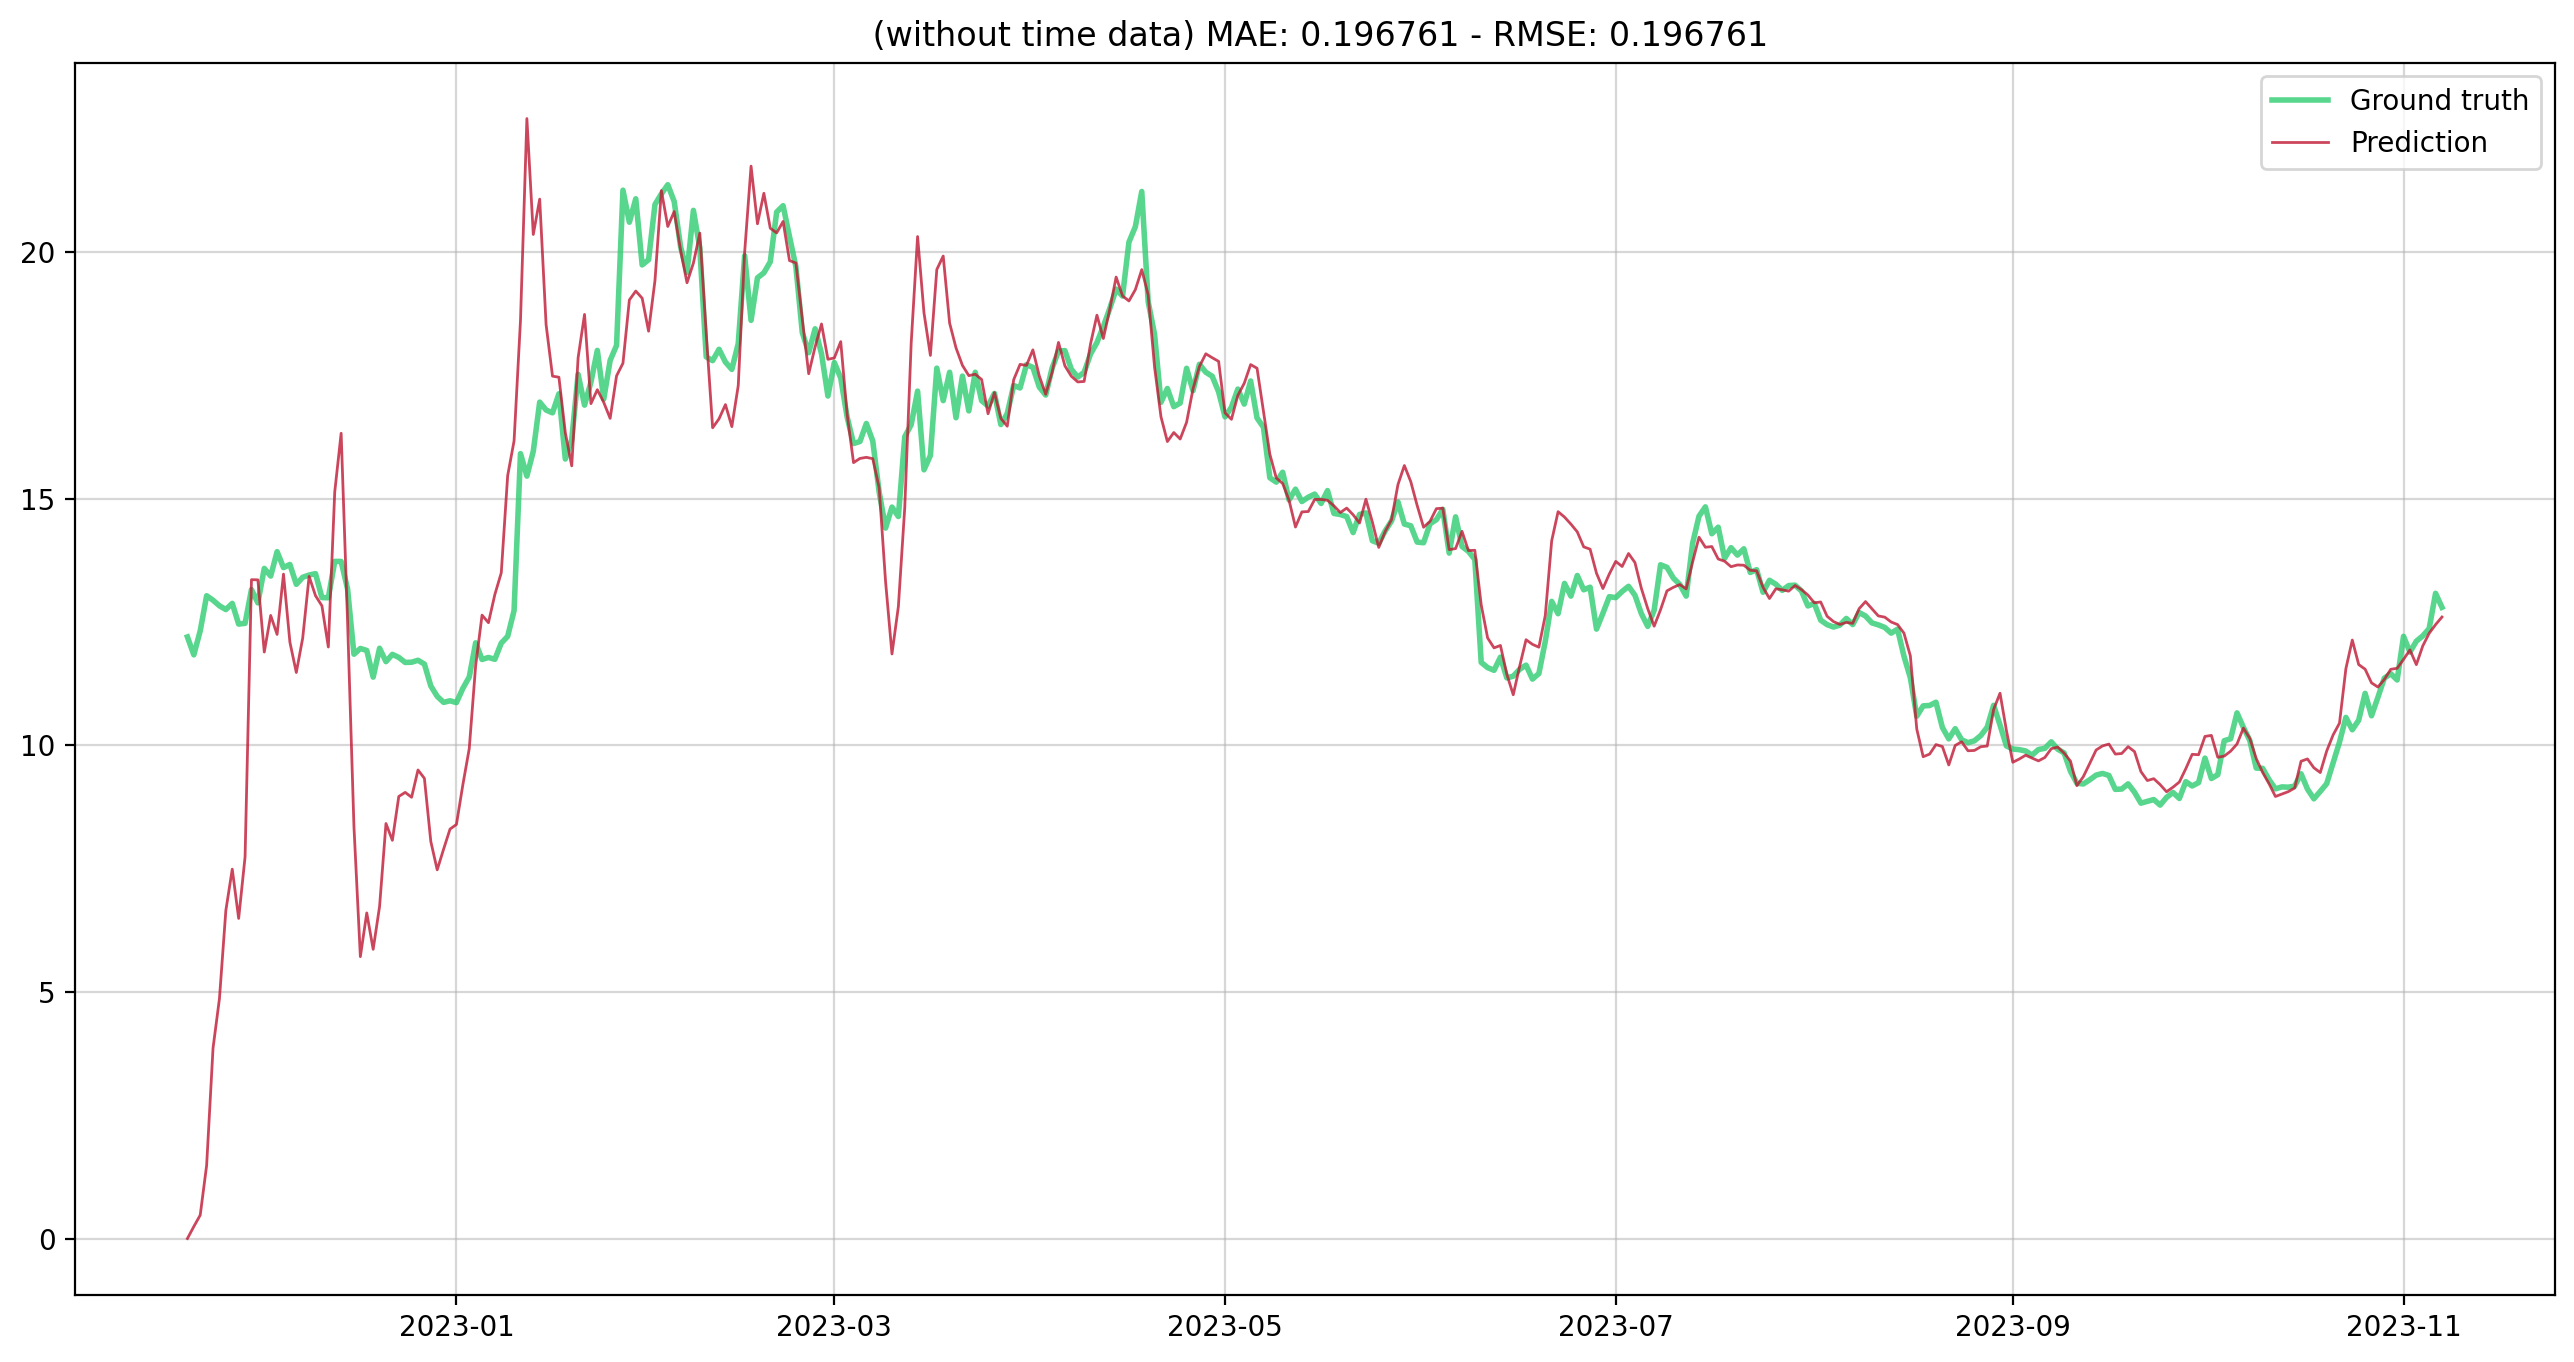

In [96]:
# Evaluating the model with 1 day timeframe

evaluate_model(X_y, model, 1, ' (without time data) ')

# With Time Series Data

In [87]:
data_avax = pd.read_csv('/Users/arturo/Downloads/AVAX-USD.csv')
data_avax.index = pd.to_datetime( data_avax['Date'])
data_avax.drop(['Adj Close', 'Volume', 'Date'], axis = 1, inplace = True)

def app_prefix(a):
    new = 'avax_' + a
    return new

data_avax.rename(app_prefix , axis='columns', inplace = True)

# -------------------------

data_btc = pd.read_csv('/Users/arturo/Downloads/BTC-USD.csv')
data_btc.index = pd.to_datetime( data_btc['Date'])
data_btc.drop(['Adj Close', 'Volume', 'Date'], axis = 1, inplace = True)

def app_prefix(a):
    new = 'btc_' + a
    return new

data_btc.rename(app_prefix , axis='columns', inplace = True)

# -------------------------
data_eth = pd.read_csv('/Users/arturo/Downloads/ETH-USD.csv')
data_eth.index = pd.to_datetime( data_eth['Date'])
data_eth.drop(['Adj Close', 'Volume', 'Date'], axis = 1, inplace = True)

def app_prefix(a):
    new = 'eth_' + a
    return new

data_eth.rename(app_prefix , axis='columns', inplace = True)


data = data_avax.join(data_btc)
data = data.join(data_eth)

y = data.pop('avax_Close')


# Creating time series feature
def creata_new_feature(df):
    df = df.copy()
    df['quarter'] = df.index.quarter

    return df

data_new = creata_new_feature(data)

data_new['quarter_sin'] = np.sin(data_new['quarter']*(2.*np.pi/4))
data_new['quarter_cos'] = np.sin(data_new['quarter']*(2.*np.pi/4))

data_new.drop(['quarter'], axis = 1, inplace = True)
data_new.head()

,avax_Open,avax_High,avax_Low,btc_Open,btc_High,btc_Low,btc_Close,eth_Open,eth_High,eth_Low,eth_Close,quarter_sin,quarter_cos
Date,,,,,,,,,,,,,
2022-11-20,12.881950,13.117833,12.131300,16712.919922,16746.779297,16248.692383,16291.832031,1218.436279,1224.077759,1137.933228,1142.466675,-2.449294e-16,-2.449294e-16
2022-11-21,12.196135,12.196135,11.647357,16291.223633,16291.223633,15599.046875,15787.284180,1142.395752,1142.395752,1084.857300,1108.353027,-2.449294e-16,-2.449294e-16
2022-11-22,11.833281,12.350505,11.492087,15782.300781,16253.047852,15656.606445,16189.769531,1107.895996,1136.442627,1081.138184,1135.173462,-2.449294e-16,-2.449294e-16
2022-11-23,12.324512,13.031652,12.324512,16195.588867,16638.193359,16170.502930,16610.707031,1135.421509,1184.997314,1130.022827,1183.199585,-2.449294e-16,-2.449294e-16
2022-11-24,13.030243,13.365598,12.805801,16611.636719,16771.474609,16501.767578,16604.464844,1183.345093,1211.627441,1180.379761,1203.983154,-2.449294e-16,-2.449294e-16


In [88]:
X_y_time_data = stream.iter_pandas(data_new, y)


model = compose.Select('avax_Open', 'avax_High', 'avax_Low', 'btc_Open',
       'btc_High', 'btc_Low', 'btc_Close', 'eth_Open', 'eth_High', 'eth_Low', 'eth_Close', 'quarter_sin', 'quarter_cos')



model |= preprocessing.MinMaxScaler()
model |= linear_model.LinearRegression(optimizer = optim.SGD(0.01))

model

Pipeline (
  Select (
    avax_High
    avax_Low
    avax_Open
    btc_Close
    btc_High
    btc_Low
    btc_Open
    eth_Close
    eth_High
    eth_Low
    eth_Open
    quarter_cos
    quarter_sin
  ),
  MinMaxScaler (),
  LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
)

/opt/anaconda3/lib/python3.9/site-packages/river/preprocessing/scale.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return a / b if b else 0.0


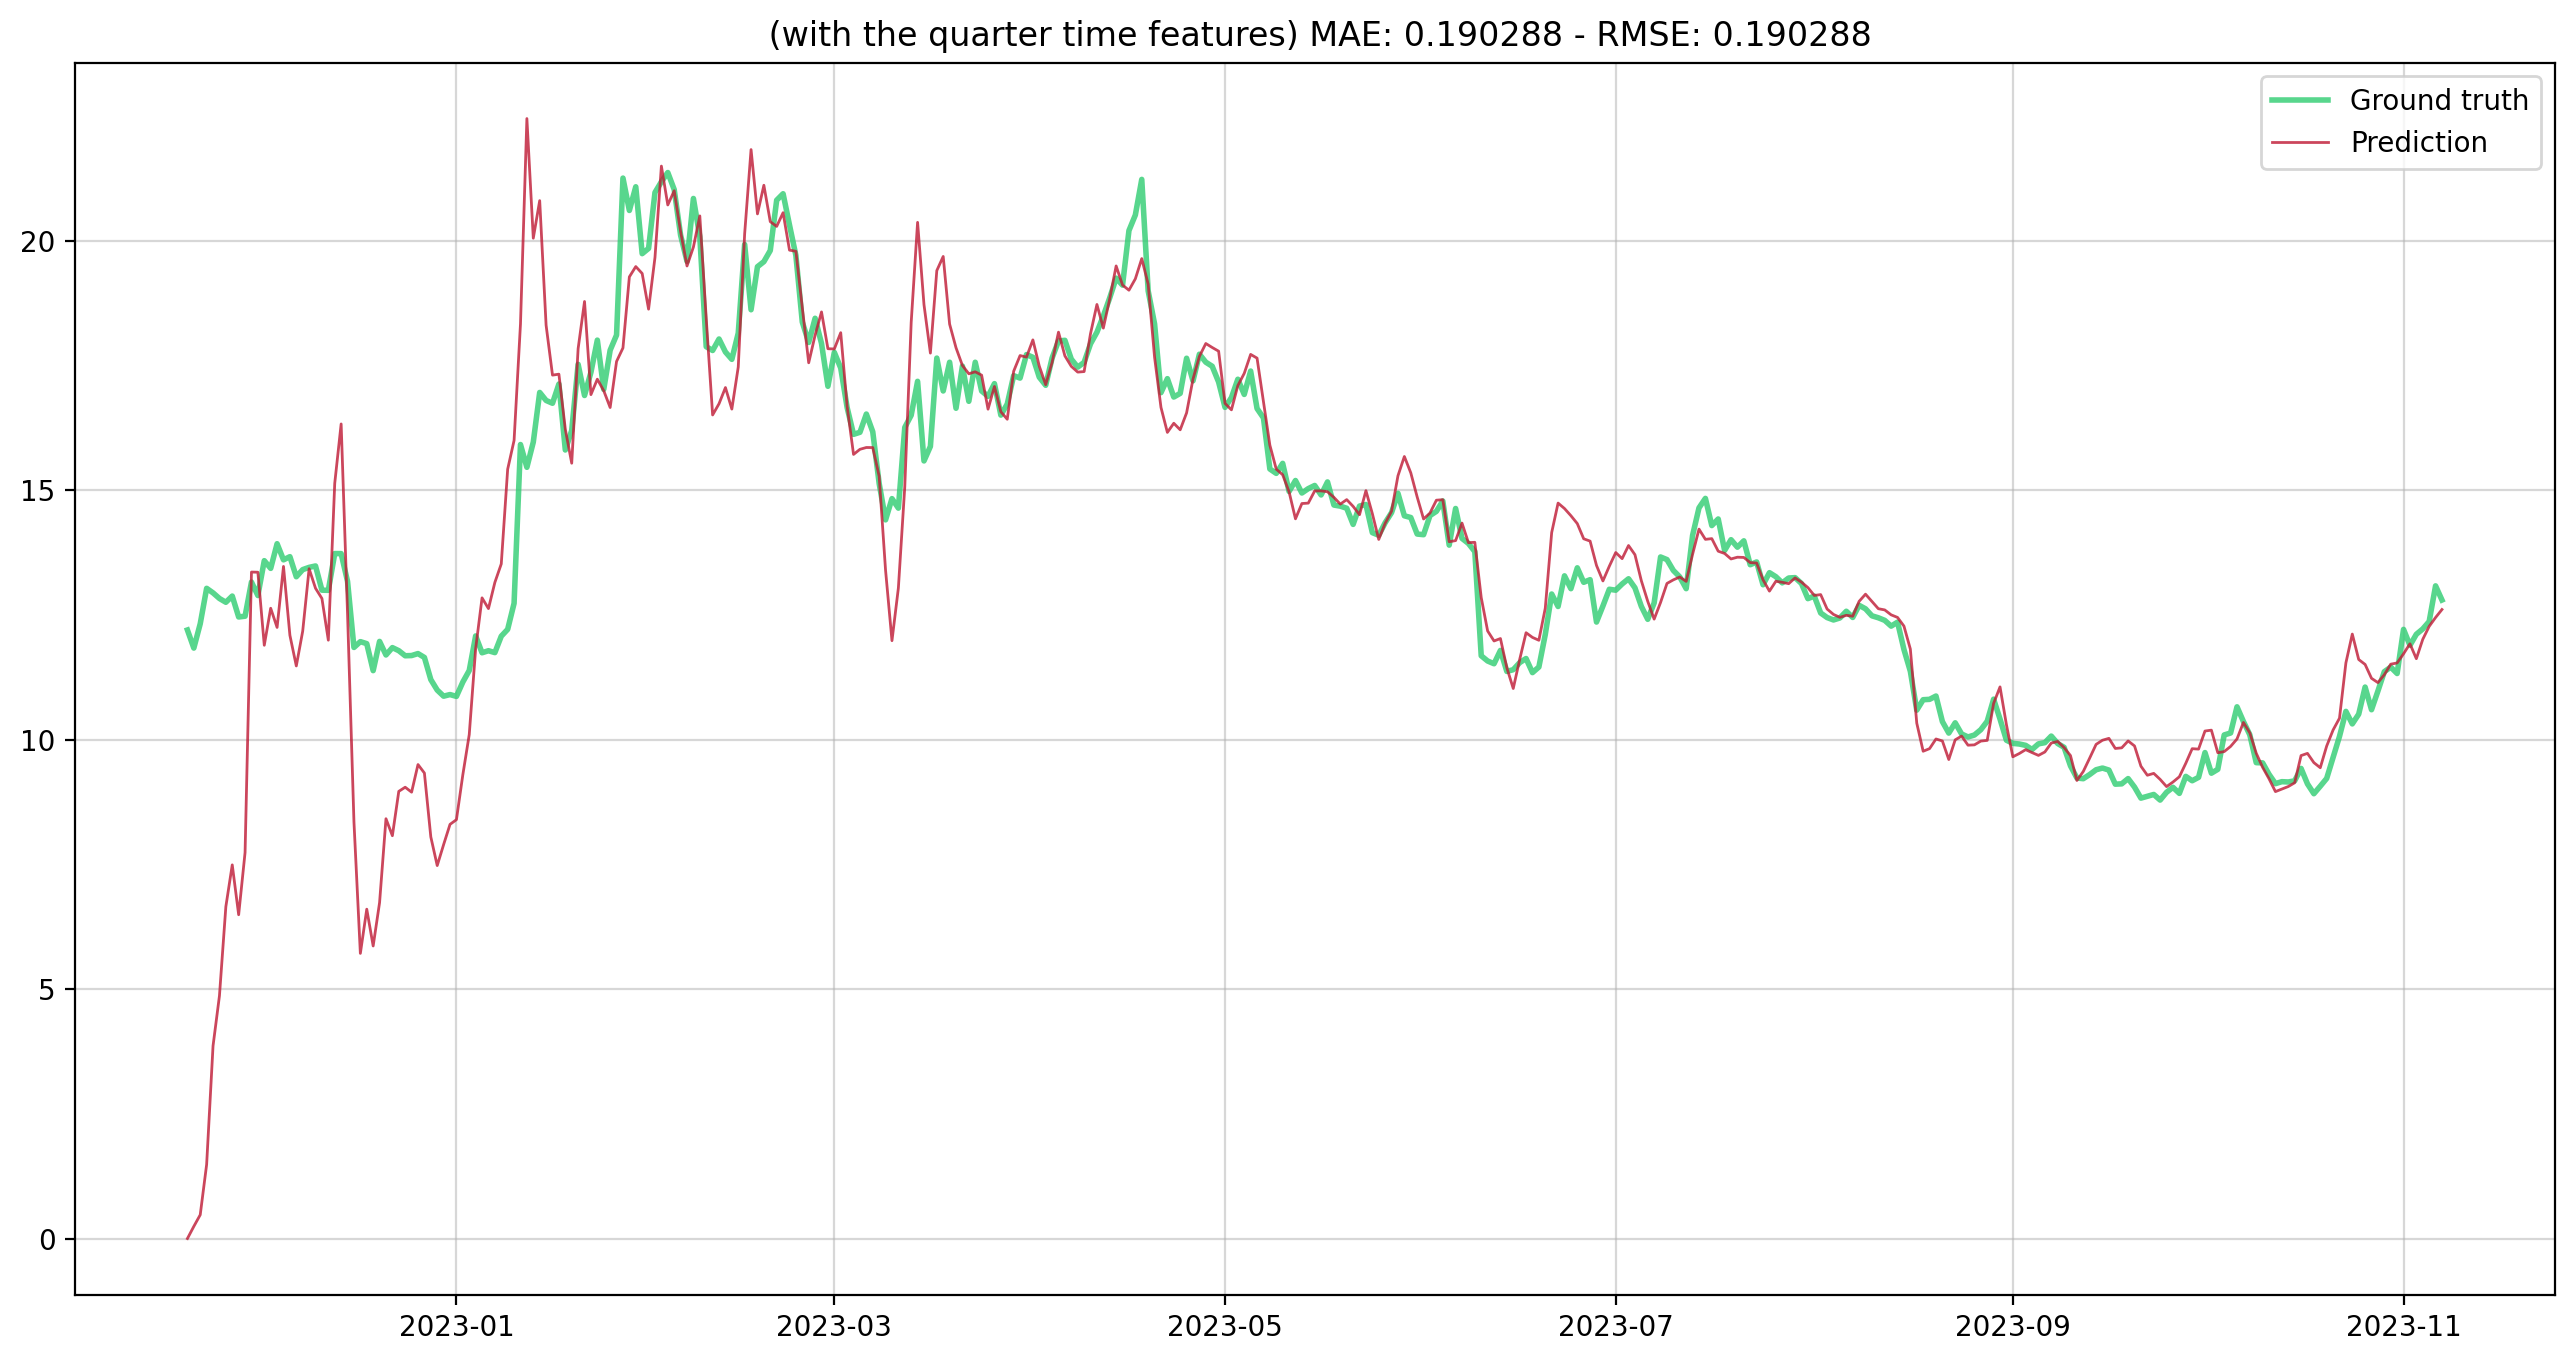

In [89]:
# Evaluating the model with 1 day timeframe

evaluate_model(X_y_time_data, model, 1,  ' (with the quarter time features) ')